In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import modred as mr
import numpy.matlib as ml
import scipy.interpolate as interp
from importlib import reload
import PODutils
import PIVutils

saveFolder = './RNV45-POD'

import os
if not os.path.exists(saveFolder):
    os.makedirs(saveFolder)

In [2]:
X, Y, U, V, Cond, Prof = PIVutils.importMatlabPIVdata('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',['X','Y','U','V'],['Cond','Prof'])

['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


In [3]:
#Rearange data into correct shape (rows all the data for a single snapshot, columns each shapshot)
uSize = U.shape
uSize

(123, 242, 750)

In [4]:
U[1,1,1]

0.79468638429797611

In [5]:
V[1,1,1]

0.029383627112309647

In [6]:
#Do 2D interpolation to remove any NaNs or find locations of NaNs 
#for i in range(uSize[2]):
#    U[:,:,i] = interp.interp2d(X, Y, U[:,:,i], kind='linear')

#Find the locations of all NaNs
NanLocs = np.isnan(U)
#U[NanLocs] = 0
    

In [7]:
#Calculate mean velocity profiles
Umean = np.nanmean(np.nanmean(U,axis=2),axis = 1)
Umean
Umean.shape

Umean = np.transpose(np.tile(Umean,(uSize[2],uSize[1],1)),(2,1,0))
#Umean.shape

#Subtract mean velocity profiles from velocity fields
Uf = U - Umean;
Vf = V; #<--Mean in vertical is aprox zero
del Umean

In [8]:
#Set all NaNs to zero so that POD can run
Uf[NanLocs] = 0
Vf[NanLocs] = 0

###### Test shape of matrix needed for POD function
num_vecs = 50;  #<-- equivalent to the number of PIV snapshots (Also number of total POD modes)

vecs = np.random.random((100, num_vecs))
vecs.shape

# New way to do POD with data handles

In [ ]:
#Check to see if you can get POD output from precomputed correlation matrix
POD = mr.PODHandles(np.vdot)
POD.correlation_mat = correlation_mat
POD.compute_eigendecomp()
#POD.get_
POD.compute_modes(range(10), [mr.VecHandleArrayText('Mode%d.txt'%i) for i in range(10)], vec_handles=snapshots)

#### And again but actually building the correlation matrix this time

In [9]:
# Define the data handles
FrameSize = 1;
#num_vecs = int(uSize[2]/FrameSize) 
num_vecs = uSize[2]
path = '/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2/'
if not os.path.exists(path):
    os.makedirs(path)
snapshots = [
    mr.VecHandleArrayText(path + 'vec%d.txt' % i) 
    for i in range(num_vecs)]

In [10]:
num_vecs

750

In [11]:
# Save the PIV data into handles
for i, snap in enumerate(snapshots):
    Unew = Uf[:,:,i*FrameSize:(i+1)*FrameSize]
    Vnew = Vf[:,:,i*FrameSize:(i+1)*FrameSize]
    uAll = np.concatenate((Unew.reshape(uSize[0]*uSize[1]), Vnew.reshape(uSize[0]*uSize[1])), axis = 0)
    snap.put(uAll)


In [12]:
uAll = np.concatenate((Unew.reshape(uSize[0]*uSize[1]), Vnew.reshape(uSize[0]*uSize[1])), axis = 0)
uAll.shape

(59532,)

In [43]:
# Calculate and save POD modes
num_modes = 50
my_POD = mr.PODHandles(np.vdot, max_vecs_per_node=1500)
eig_vals, eig_vecs = my_POD.compute_decomp(snapshots)

Computing the inner product matrix will take at least 3.1 minutes


Completed 100.0% of inner products


In [44]:
print(eig_vecs.shape)
print(eig_vals.shape)

(750, 750)
(750,)


In [45]:
mode_handle = [
    mr.VecHandleArrayText(path + 'Mode%d.txt' % i) 
    for i in range(num_modes)]
my_POD.compute_modes(range(num_modes), mode_handle)

Linear combinations will take at least 4.2 minutes
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 0.0% of linear combinations
Completed 100.0% of linear combinatio

In [76]:
modes = np.zeros((uAll.shape[0],num_modes))
for i, modeins in enumerate(mode_handle):
    modes[:,[i]] = modeins.get()

In [77]:
modes.mean()

6.0927196995535679e-06

In [78]:
modes[:,i].shape

(59532,)

In [79]:
C = my_POD.compute_proj_coeffs()

In [80]:
C.shape

(750, 750)

# Start analysis on result

In [82]:
menergy = eig_vals/np.sum(eig_vals)
menergy_sum = np.zeros(len(menergy))
for i in range(len(menergy)):
    menergy_sum[i] = np.sum(menergy[:i]);

In [83]:
reload(PODutils)
Umodes, Vmodes= PODutils.reconstructPODmodes(modes,uSize,num_modes,2)

In [84]:
modes.dtype

dtype('float64')

fig, ax = plt.subplots()
ax.bar(range(num_modes),menergy[1:num_modes]*100)

# Plot modal energy and contribution total

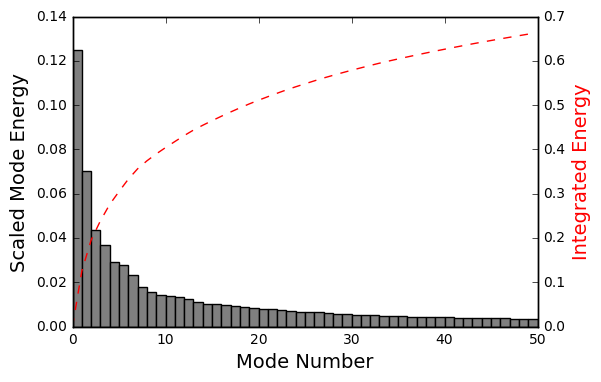

In [85]:
ind = np.arange(num_modes)  # the x locations for the groups
width = 1       # the width of the bars

f = plt.figure()
ax = plt.gca()
ax2 = plt.twinx()
rect = ax.bar(ind,menergy[:num_modes], width, color='gray')
line = ax2.plot(ind,menergy_sum[:num_modes],'--r')

ax.set_xlabel("Mode Number",fontsize=14)
ax.set_ylabel("Scaled Mode Energy",fontsize=14)
ax2.set_ylabel("Integrated Energy",fontsize=14,color='red')

f.savefig(saveFolder + '/ModeEnergy.pdf', transparent=True, bbox_inches='tight', pad_inches=0)

# Plot some modes

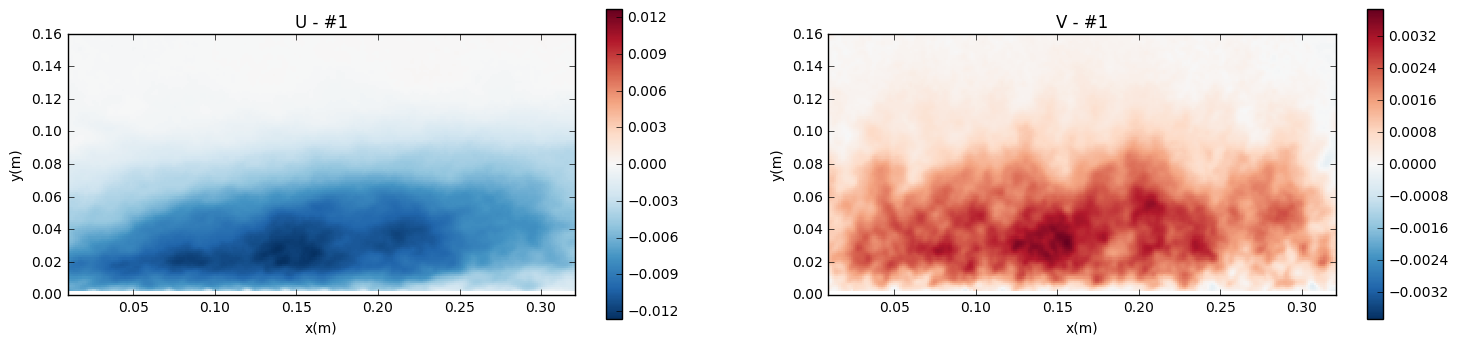

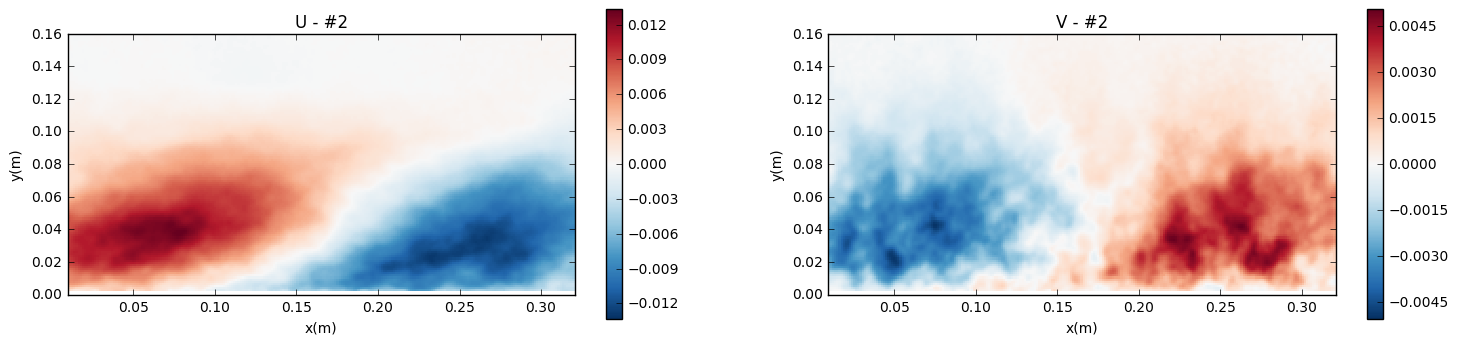

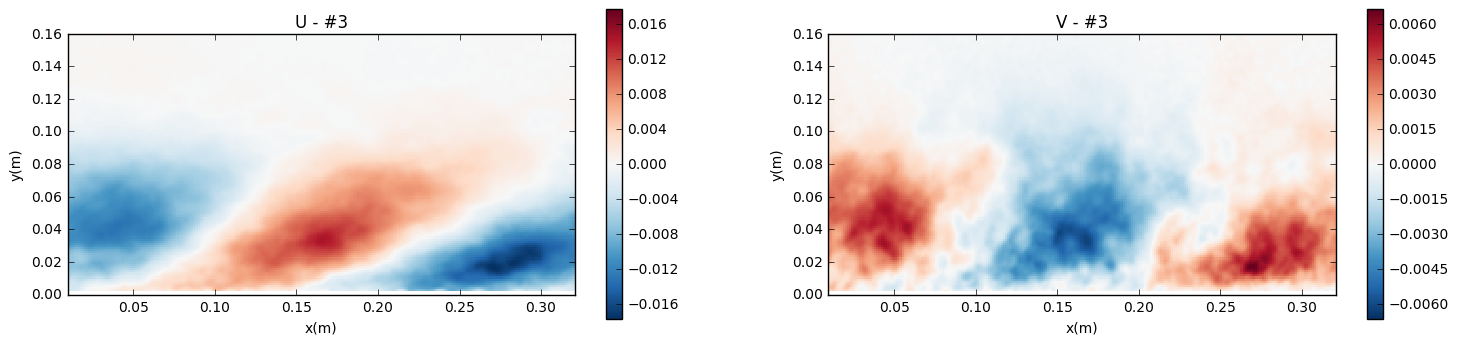

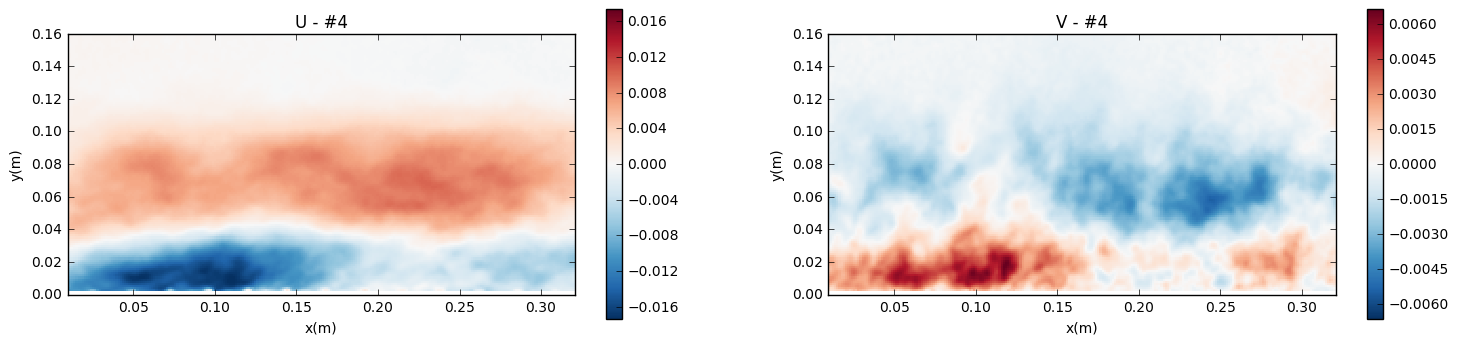

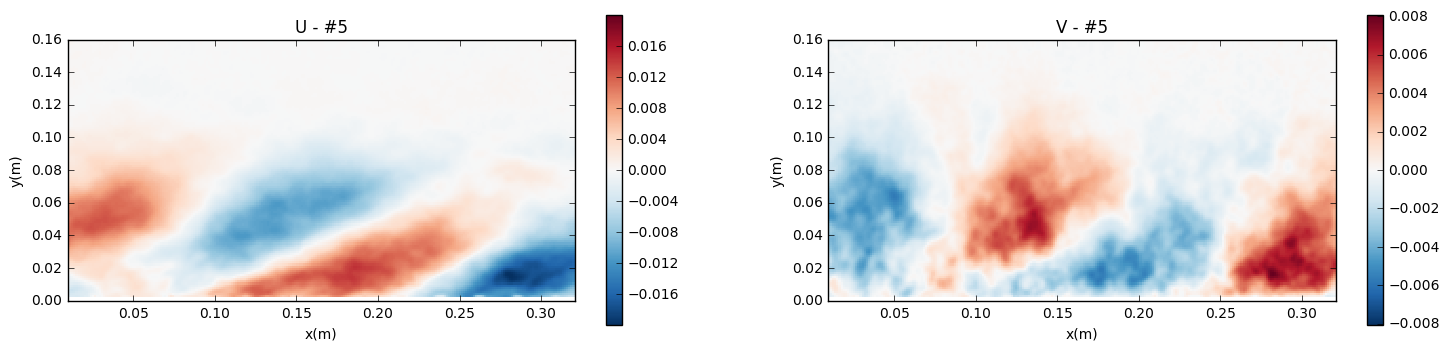

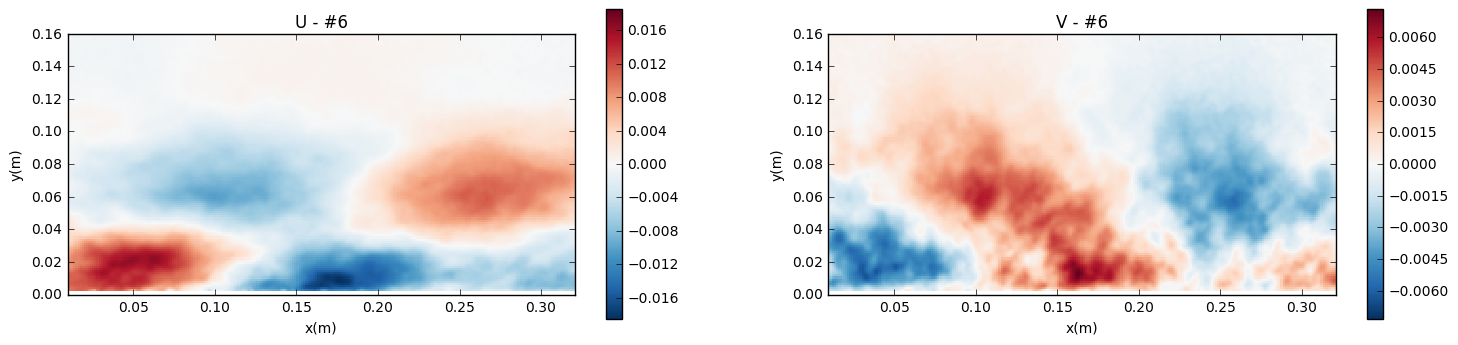

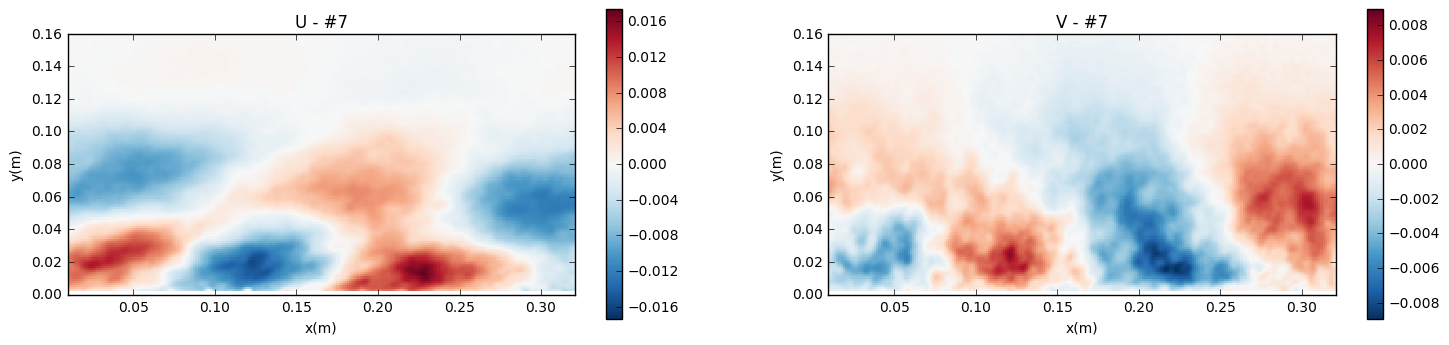

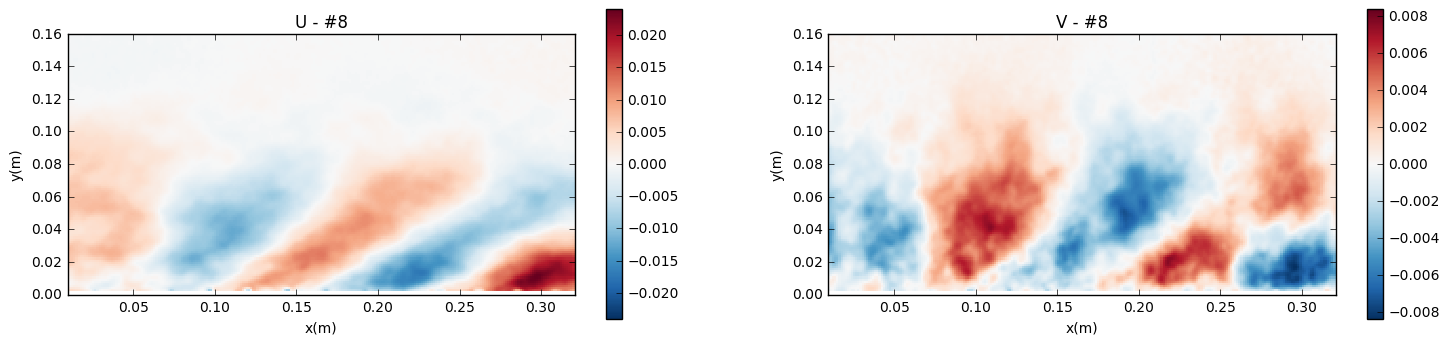

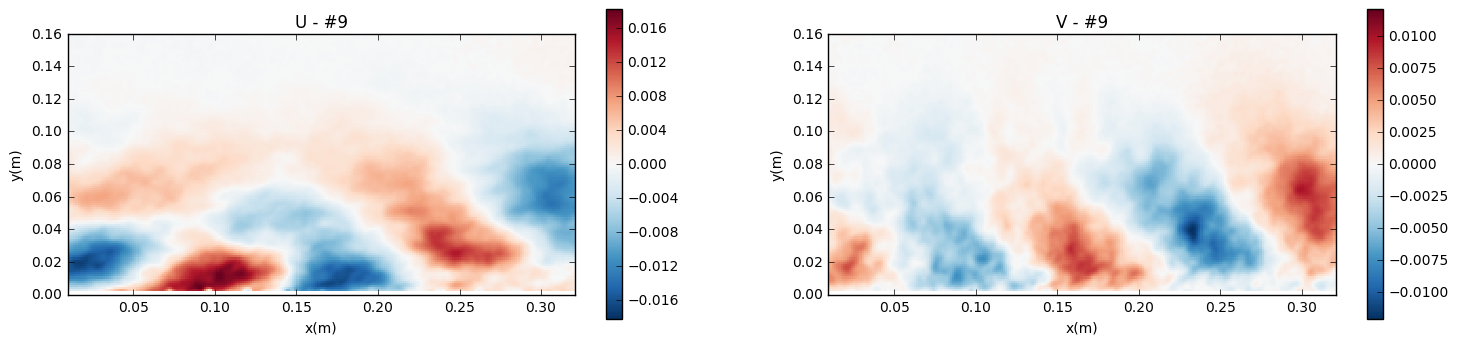

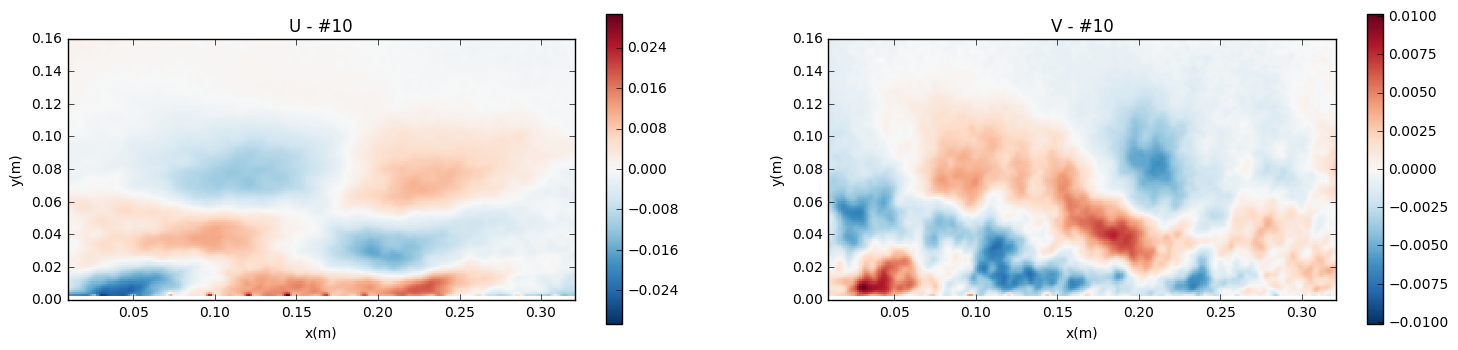

In [86]:
reload(PODutils)
PODutils.plotPODmodes2D(X,Y,Umodes,Vmodes,list(range(10)),saveFolder)

# Plot the variation of the coefficients

In [56]:
reload(PODutils)
PODutils.plotPODcoeff(C,list(range(6)),50,saveFolder=(saveFolder + '/Coeff.tif'))

ValueError: too many values to unpack (expected 2)